In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.dates as mdates

from phl import previous_high_low
from phl import session

In [2]:
# Import and Formatting Data

# EURUSD
df_eu = pd.read_pickle('EUR_USD_H1.pkl')
df_eu['day'] = pd.to_datetime(df_eu['time']).dt.day_of_week
df_eu = df_eu[df_eu['day'] != 6]
df_eu = df_eu.reset_index(drop=True)
df_eu = df_eu.rename(columns={'mid_o': 'open', 'mid_h': 'high', 'mid_l': 'low', 'mid_c': 'close'})
df_eu = df_eu[['time', 'open', 'high', 'low', 'close', 'volume']]

# BTCUSD
df_btc = pd.read_csv('BTC_USDT_H1.csv')
df_btc = df_btc.reset_index(drop=True)
df_btc = df_btc.rename(columns={'Date': 'time', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'})
df_btc = df_btc[['time', 'open', 'high', 'low', 'close', 'volume']]

# US500
df_us500 = pd.read_csv('US500_USD_H1.csv')
df_us500['day'] = pd.to_datetime(df_us500['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f').dt.day_of_week
df_us500 = df_us500[df_us500['day'] != 6]
df_us500 = df_us500.reset_index(drop=True)
df_us500 = df_us500.rename(columns={'Gmt time': 'time', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'})
df_us500['time'] = pd.to_datetime(df_us500['time'], format='%d.%m.%Y %H:%M:%S.%f')
df_us500['time'] = df_us500['time'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [3]:
'''
Фильтрация DF с целью поиска свечей, которые:
- Начинают новый диапазона (Если timeframe = 1W, то начало - новая недея) и обозначают Previous High и Previous Low
- Первая свеча, которая прошла Previous High или Previous Low
'''
def unique_data(phl_data, df):
    df['day'] = pd.to_datetime(df['time']).dt.day_of_week
    phl_data = phl_data.drop_duplicates()
    mask = df.index.isin(phl_data.index)
    df = df[mask]

    df = df.copy()
    for i in range(len(df)):
        if df.iloc[i]['pwh_break'] == 1 and df.iloc[i]['pwl_break'] == 1 and df.iloc[i-1]['pwh_break'] == 1:
            df.at[df.index[i], 'pwh_break'] = 0
        if df.iloc[i]['pwh_break'] == 1 and df.iloc[i]['pwl_break'] == 1 and df.iloc[i-1]['pwl_break'] == 1:
            #phl_data.iloc[i]['pwl_break'] = 0
            df.at[df.index[i], 'pwl_break'] = 0

    return df
'''
Поиск индекса свечи, которая сформировала Previous High и Previous Low
Возвращает 2 новых столбца в DF с индексами PH и PL
'''
def pwh_pwl_original_idx(df, pwh_pwl_data):

    df = df.copy()
    df['day_name'] = pd.to_datetime(df['time']).dt.strftime('%A')
     

    origin_high_idx_mask = np.zeros(len(pwh_pwl_data), dtype=np.int32)
    origin_low_idx_mask = np.zeros(len(pwh_pwl_data), dtype=np.int32)
    day_form_high_mask = np.zeros(len(pwh_pwl_data), dtype=f'<U{10}')
    day_form_low_mask = np.zeros(len(pwh_pwl_data), dtype=f'<U{10}')

    for i in range(len(pwh_pwl_data)):
        if not np.isnan(pwh_pwl_data.iloc[i]['pwh']) and not np.isnan(pwh_pwl_data.iloc[i]['pwl']):

            #print(pwh_pwl_data.iloc[i].name)

            if pwh_pwl_data.iloc[i].name <= len(df):

                pwh = pwh_pwl_data.iloc[i]['pwh']
                pwl = pwh_pwl_data.iloc[i]['pwl']

                # Поиск всех индексов, которые выполняют условие
                matched_all_highs_indices = df[np.isclose(df['high'], pwh, atol=1e-5)].index
                matched_all_lows_indices = df[(np.isclose(df['low'], pwl, atol=1e-5))].index

                # Определения дня в который сформировался PWH / PWL
                #names_of_days = df.iloc


                # Поиск индексов, которые меньше текущего значения pwh_pwl_data.iloc[i].name
                # для того, чтоб получить список индексов хаев лоев до текущей свечи. То есть хаи лои до текущей недели
                matched_previous_highs_indices = []
                matched_previous_lows_indices = []

                for n in matched_all_highs_indices:
                    if n <= pwh_pwl_data.iloc[i].name:
                        matched_previous_highs_indices.append(n)
                for n in matched_all_lows_indices:
                    if n <= pwh_pwl_data.iloc[i].name :
                        matched_previous_lows_indices.append(n)
                
                if len(matched_previous_highs_indices) > 0:
                    origin_high_idx_mask[i] = matched_previous_highs_indices[-1]
                    day_form_high_mask[i] = df.loc[matched_previous_highs_indices[-1]]['day_name']
                if len(matched_previous_lows_indices) > 0:
                    origin_low_idx_mask[i] = matched_previous_lows_indices[-1]
                    day_form_low_mask[i] = df.loc[matched_previous_lows_indices[-1]]['day_name']

    origin_high_idx = pd.Series(origin_high_idx_mask, name='org_high_idx', index=pwh_pwl_data.index)
    origin_low_idx = pd.Series(origin_low_idx_mask, name='org_low_idx', index=pwh_pwl_data.index)
    day_form_high = pd.Series(day_form_high_mask, name='day_form_high', index=pwh_pwl_data.index)
    day_form_low = pd.Series(day_form_low_mask, name='day_form_low', index=pwh_pwl_data.index)

    origins_idxs = pd.concat([origin_high_idx, origin_low_idx, day_form_high, day_form_low], axis=1)

    pwh_pwl_data = pwh_pwl_data.merge(origins_idxs, left_index=True, right_index=True)

    return pwh_pwl_data

# Plotting Charts
def plotting_charts(df, pl_data, offset, name):
    dfm = df.copy()
    dfc = df.copy()
    dfc['time'] = pd.to_datetime(dfc['time'])

    pl_data = pl_data.copy()
    pl_data['day_name'] =pd.to_datetime(pl_data['time']).dt.strftime('%A')
    

    dfc.index = pd.DatetimeIndex(dfc['time'])

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=0))  # Метки на конец недели
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Формат даты

    mpf.plot(dfc, type='candle', ax=ax, volume=False, show_nontrading=False)

    for i, row in pl_data.iterrows():
        if not pd.isnull(row['pwh']):
            if row['pwh_break'] == 1:
                color = 'green'
            elif row['pwl_break'] == 1:
                color = 'red'
            else:
                color = 'black'

            
            if not row['org_high_idx'] - offset < 0 and not row['org_low_idx'] - offset < 0:    
                ax.hlines(y=row['pwh'], xmin=row['org_high_idx'] - offset, xmax=i - offset, color=color, linestyle='-', linewidth=2)
                ax.hlines(y=row['pwl'], xmin=row['org_low_idx'] - offset, xmax=i - offset, color=color, linestyle='-', linewidth=2)
                
                if row['pwh_break'] == 0 and row['pwl_break'] == 0:
                    ax.text(row['org_high_idx'] - offset, row['pwh'], 
                                f"PWH - {row['day_form_high']}", 
                                fontsize=8, verticalalignment='top', horizontalalignment='left')
                    ax.text(row['org_low_idx'] - offset, row['pwl'], 
                                f"PWL - {row['day_form_low']}", 
                                fontsize=8, verticalalignment='bottom', horizontalalignment='left')

                if row['pwh_break'] == 1:
                    ax.scatter(x=i-offset, y=row['pwh'], color=color, marker='o', s=35, label='Break PWH')
                elif row['pwl_break'] == 1:
                    ax.scatter(x=i-offset, y=row['pwl'], color=color, marker='o', s=35, label='Break PWL')
                    
                    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))

    plt.legend(by_label.values(), by_label.keys(), title='Markers')
    ax.set_title(f'{name}\nPrice Movement with Detected Previous Weekly High / Low')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.grid(True)

    plt.xticks(rotation=45, ha='right')
    plt.show()

# Plotting Diagrams
def plotting_diagrams(dfs_for_plot, name, session=False):

    for df_pl, name in zip(dfs_for_plot, name):
        
        fig, ax1 = plt.subplots(figsize=(12, 6))
        
        if session:  

            sns.barplot(x='day_name', y='pwh_pwl_break', hue='kz', data=df_pl, ax=ax1, alpha=0.9)

            ax1.set_title(f'{name}\nNumber of PWH/PWL Breakthroughs for each Day of Week and each Session of Day')
            ax1.set_xlabel('Day of Week')
            ax1.set_ylabel('Number of Breakout PWH/PWL')

            custom_labels = ['Asia', 'London', 'New-York', 'PM']
            handles, _ = ax1.get_legend_handles_labels()
            ax1.legend(handles=handles, labels=custom_labels, title='Day Name', loc='upper right')

        else:
            df_pl = df_pl.reset_index()

            sns.barplot(x='day_name', y='pwh_pwl_break', hue='day_name', data=df_pl, ax=ax1, alpha=0.9)

            ax1.set_title(f'{name}\nNumber of PWH/PWL Breakthroughs for each Day of Week')
            ax1.set_xlabel('Day of Week')
            ax1.set_ylabel('Number of Breakout PWH/PWL')

        plt.show()


# Formatting Data for Plotting
def formatting_and_plotting(df_pwh_pwl_pairs, dfs, names, idx_from=0, idx_to=500):

    pairs_for_plotting = []

    # Формирование ДФ со занчениям PWH / PWL для указанного диапазона
    for df_pwh_pwl_pair in df_pwh_pwl_pairs:
        df_pwh_pwl_pair = df_pwh_pwl_pair.copy()

        df_pwh_pwl_pair['idx'] = df_pwh_pwl_pair.index

        index_from_found = False
        index_to_found = False

        index_from = idx_from
        index_to = idx_to

        while not index_from_found or not index_to_found:

            start = df_pwh_pwl_pair[df_pwh_pwl_pair['idx'] == index_from]['idx']
            end = df_pwh_pwl_pair[df_pwh_pwl_pair['idx'] == index_to]['idx']

            if len(start) > 0:
                index_from = start.iloc[0]
                index_from_found = True
            else:
                index_from +=1
            
            if len(end) > 0:
                index_to = end.iloc[0]
                index_to_found = True
            else:
                index_to +=1

        df_pwh_pwl_pair = df_pwh_pwl_pair.loc[index_from:index_to]

        pair_for_plotting = df_pwh_pwl_pair.drop(['open', 'close', 'low', 'high'], axis=1)


        pairs_for_plotting.append(pair_for_plotting)


    for pair in range(len(dfs)):
        full_df = dfs[pair].copy()
        part_df = full_df.loc[idx_from:idx_to]
        name = names[pair]
        plotting_charts(part_df, pairs_for_plotting[pair], offset=idx_from, name=name)

def final_formatting(df_pwh_pwl_pairs, session=False):

    pairs_for_analyse = []

    for df_pwh_pwl_pair in df_pwh_pwl_pairs:

        pair_an = df_pwh_pwl_pair[(df_pwh_pwl_pair['pwh_break'] == 1) | (df_pwh_pwl_pair['pwl_break'] == 1)]
        pair_an = pair_an.copy()
        pair_an['date'] = pd.to_datetime(pair_an['time']).dt.date
        pair_an['day_name'] = pd.to_datetime(pair_an['date']).dt.strftime('%A')

        pairs_for_analyse.append(pair_an)

    grouped_dfs = []

    for df in pairs_for_analyse:

        df = df.copy()

        if session:
            days_session_grouped = df.groupby(['day_name', 'day', 'kz']).agg({'pwh_break': 'sum', 'pwl_break': 'sum'})
            days_session_grouped['pwh_pwl_break'] = days_session_grouped['pwh_break'] + days_session_grouped['pwl_break']
            days_session_grouped = days_session_grouped.sort_values(by='day')
            grouped_dfs.append(days_session_grouped)
        else:
            days_grouped = df.groupby(['day_name']).agg({'pwh_break': 'sum', 'pwl_break': 'sum'})
            days_grouped['pwh_pwl_break'] = days_grouped['pwh_break'] + days_grouped['pwl_break']
            days_grouped = days_grouped.sort_values(by='pwh_pwl_break', ascending=False)
            grouped_dfs.append(days_grouped)
    
    return grouped_dfs

In [4]:
# Determination PDH, PDL, Session

def determintation_instruments(dfs, time_frame='1W'):

    df_pwh_pwl_pairs = []
    pwh_pwl_pairs = []

    for df_pair in dfs:

        df_pair = df_pair.copy()

        df_pwh_pwl_pair, pwh_pwl_pair = previous_high_low(ohlc=df_pair, time_frame=time_frame)
        df_pwh_pwl_pair = session(df_pwh_pwl_pair)
        df_pwh_pwl_pair = unique_data(pwh_pwl_pair, df_pwh_pwl_pair)
        df_pwh_pwl_pair = pwh_pwl_original_idx(df_pair, df_pwh_pwl_pair)

        df_pwh_pwl_pairs.append(df_pwh_pwl_pair)
        pwh_pwl_pairs.append(pwh_pwl_pair)

    return df_pwh_pwl_pairs, pwh_pwl_pairs

dfs = [df_eu, df_btc, df_us500]

df_pwh_pwl_pairs, pwh_pwl_pairs = determintation_instruments(dfs=dfs, time_frame='1W')
df_pwh_pwl_eu, df_pwh_pwl_btc, df_pwh_pwl_us500 = df_pwh_pwl_pairs
pwh_pwl_eu, pwh_pwl_btc, pwh_pwl_us500 = pwh_pwl_pairs


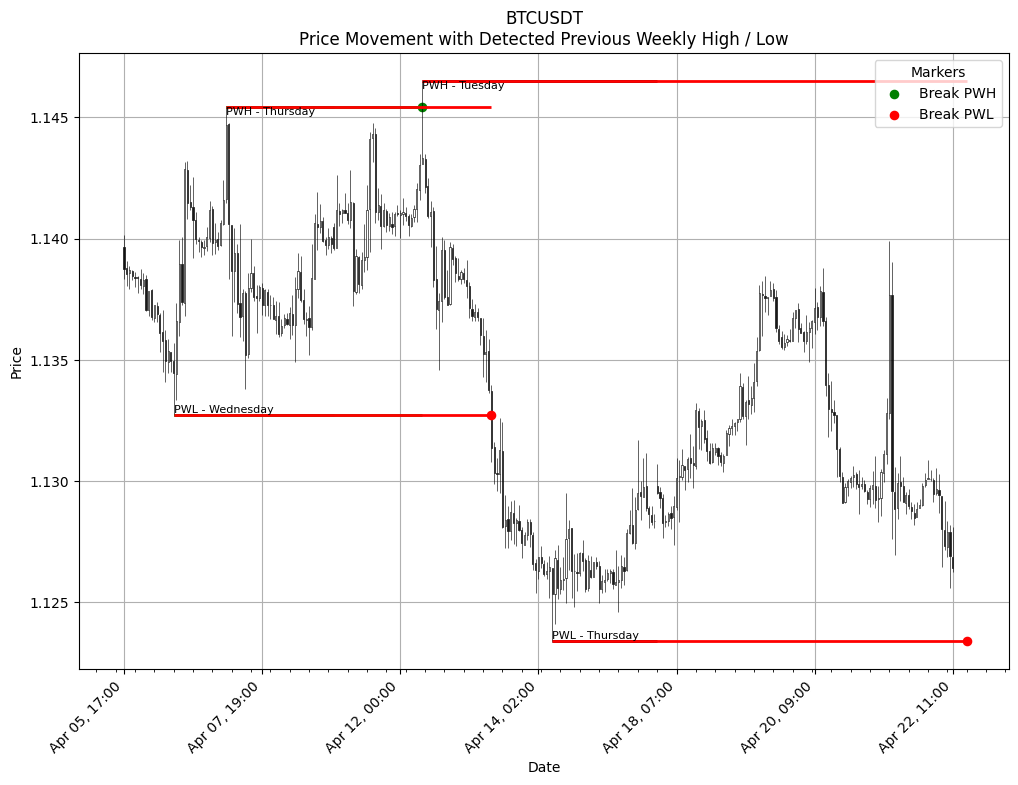

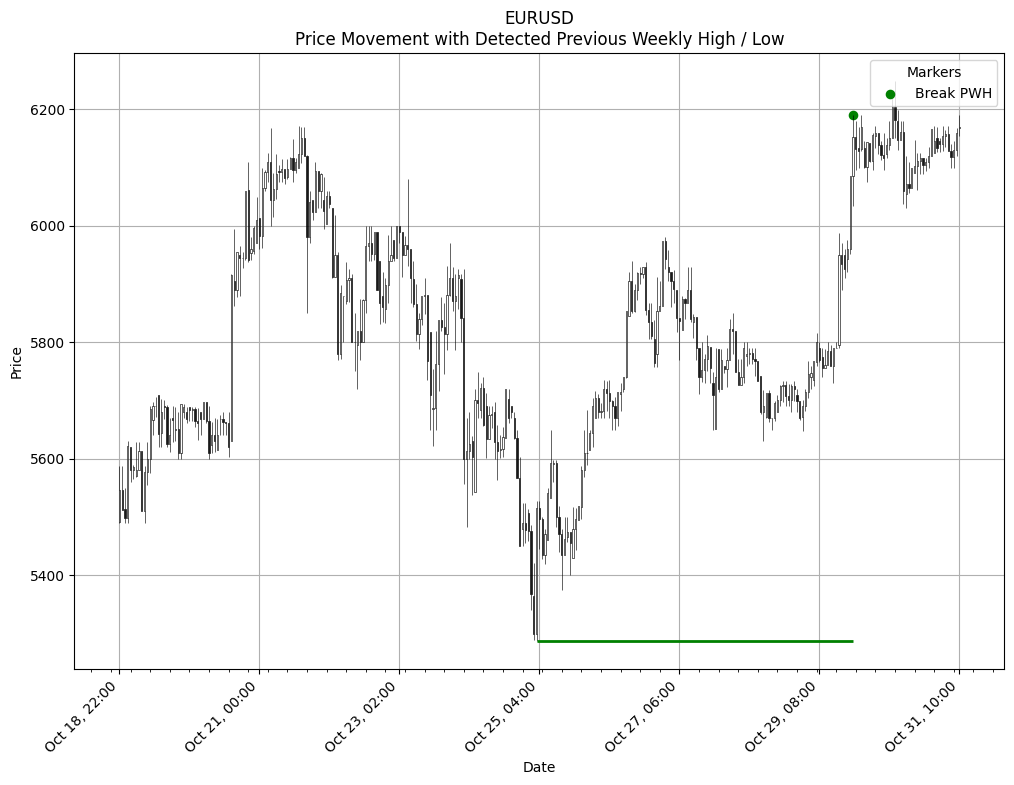

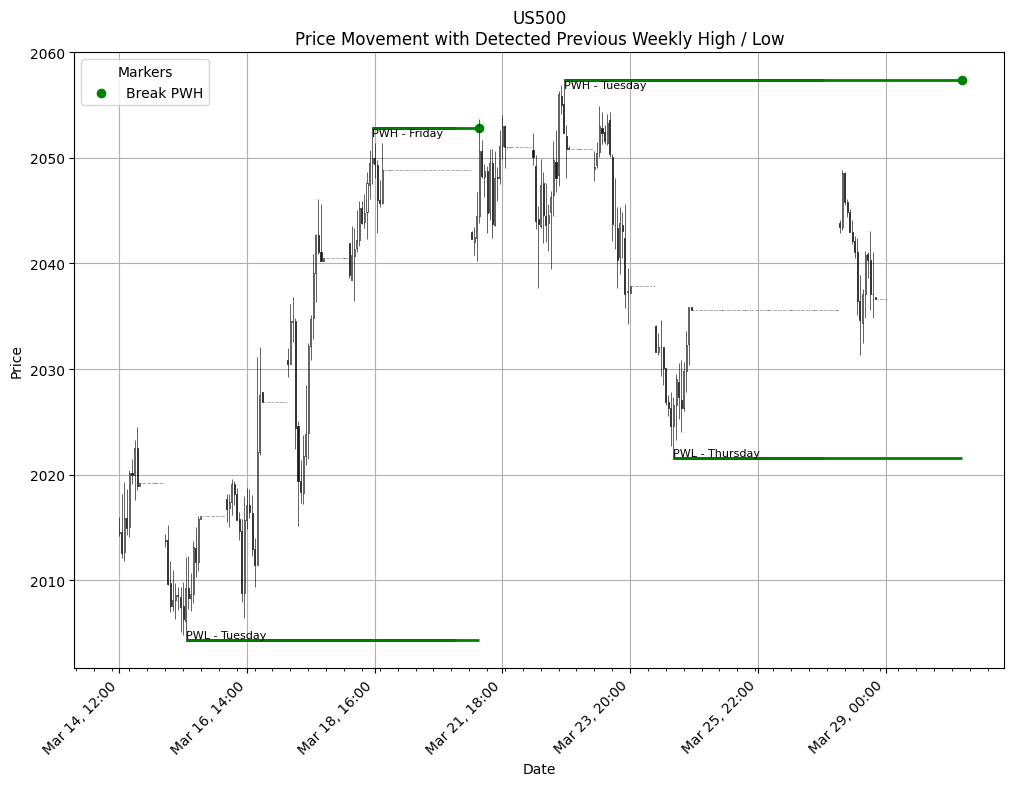

In [5]:
# Plotting Charts with Detected PWH/PWL
dfs = [df_eu, df_btc, df_us500]
df_pwh_pwl_pairs = [df_pwh_pwl_eu, df_pwh_pwl_btc, df_pwh_pwl_us500]
names = ['BTCUSDT','EURUSD', 'US500']

# idx_from, idx_to - candles data range for charting
formatting_and_plotting(df_pwh_pwl_pairs=df_pwh_pwl_pairs, dfs=dfs, names=names, idx_from=1500, idx_to=1800)

In [6]:
# Final formatting DF for analys
df_pwh_pwl_eu_pairs = [df_pwh_pwl_eu, df_pwh_pwl_btc, df_pwh_pwl_us500]

# DF's grouped by days
eu_an_days_grouped, btc_an_days_grouped, us500_an_days_grouped = final_formatting(df_pwh_pwl_pairs=df_pwh_pwl_eu_pairs, session=False)
# Df's grouped by sessions and days
eu_an_days_sessions_grouped, btc_an_days_sessions_grouped, us500_an_days_sessions_grouped = final_formatting(df_pwh_pwl_pairs=df_pwh_pwl_eu_pairs, session=True)

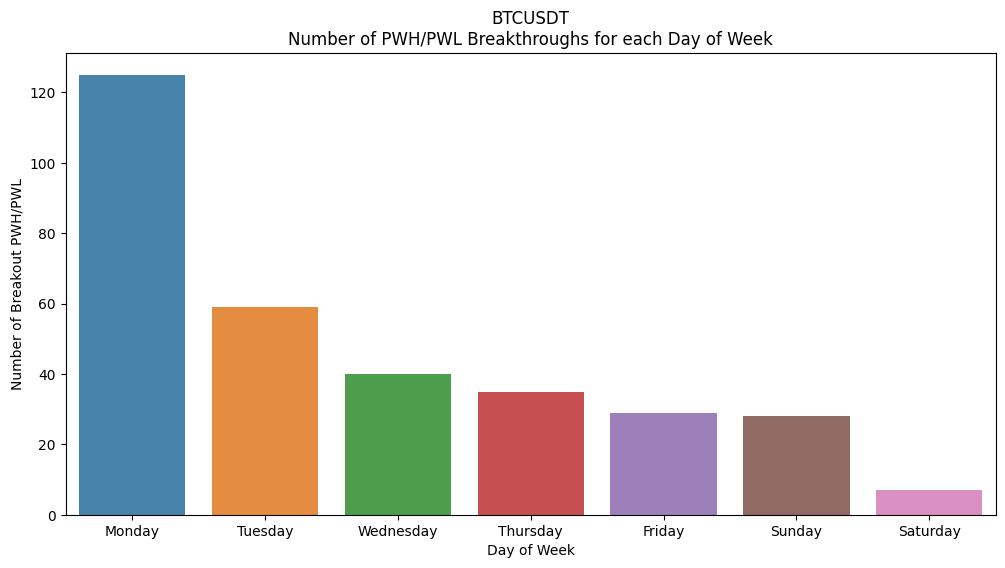

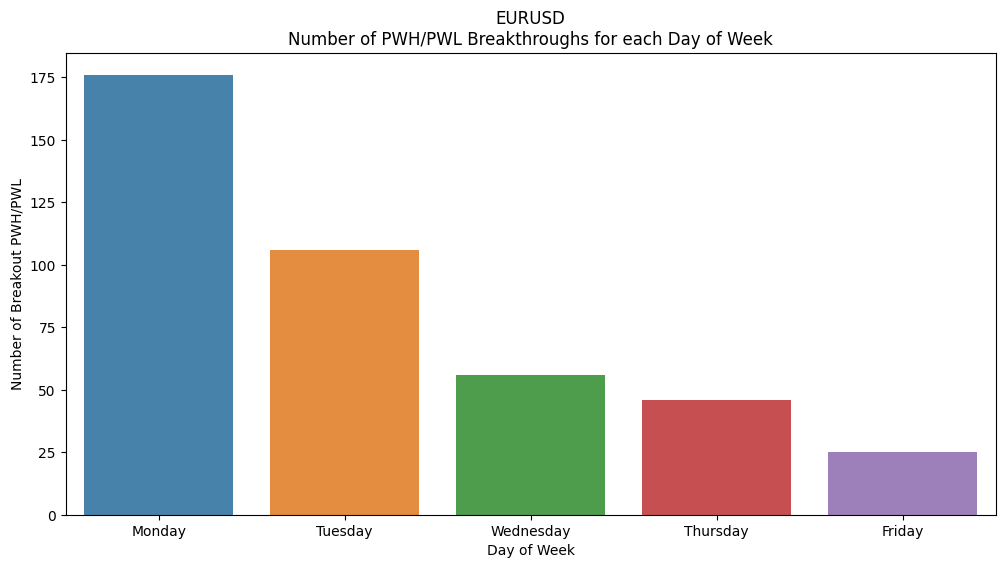

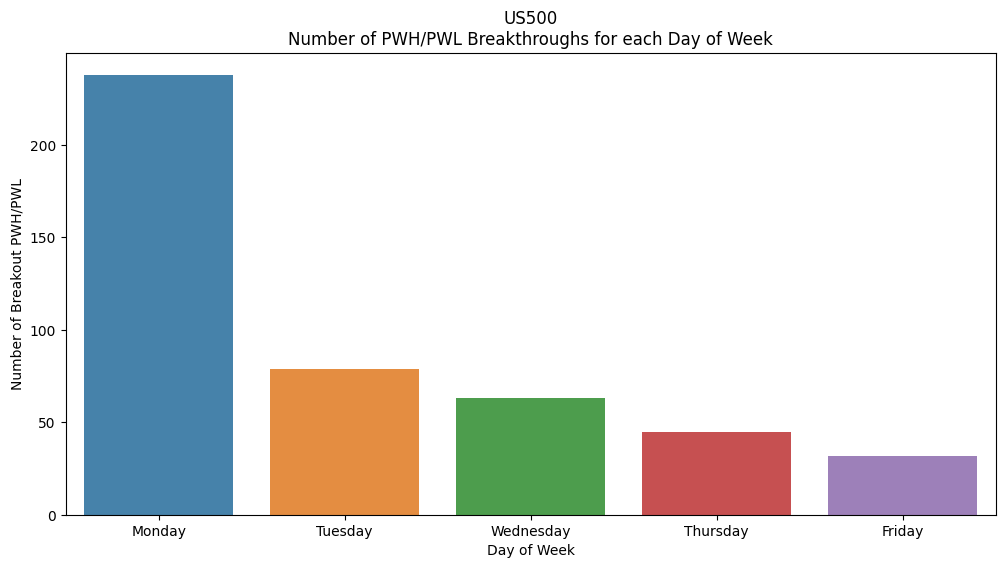

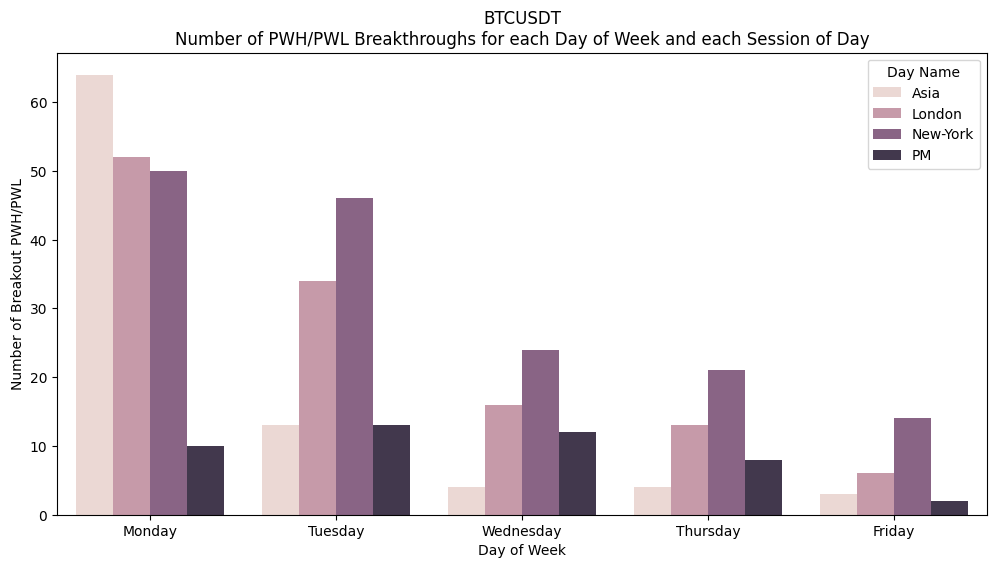

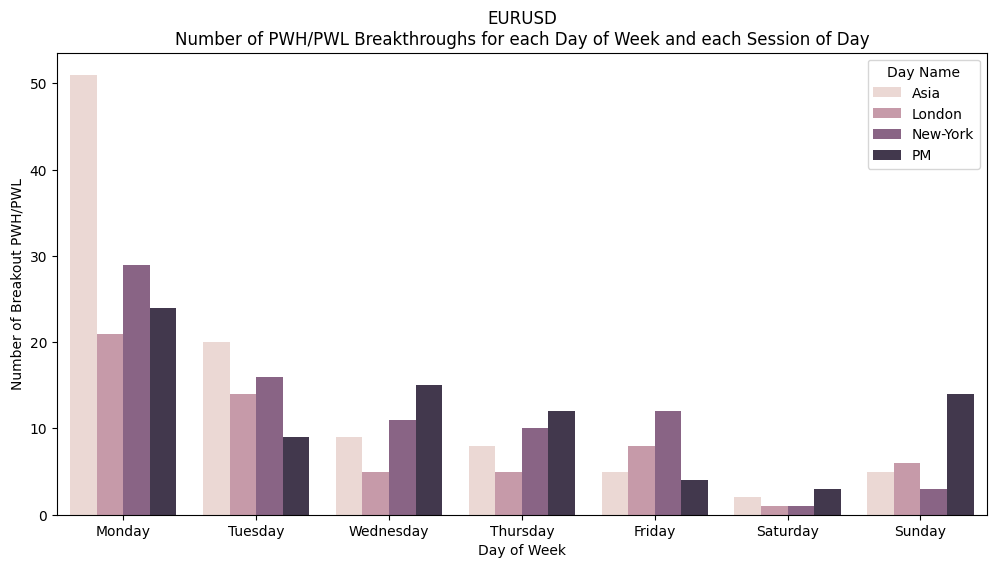

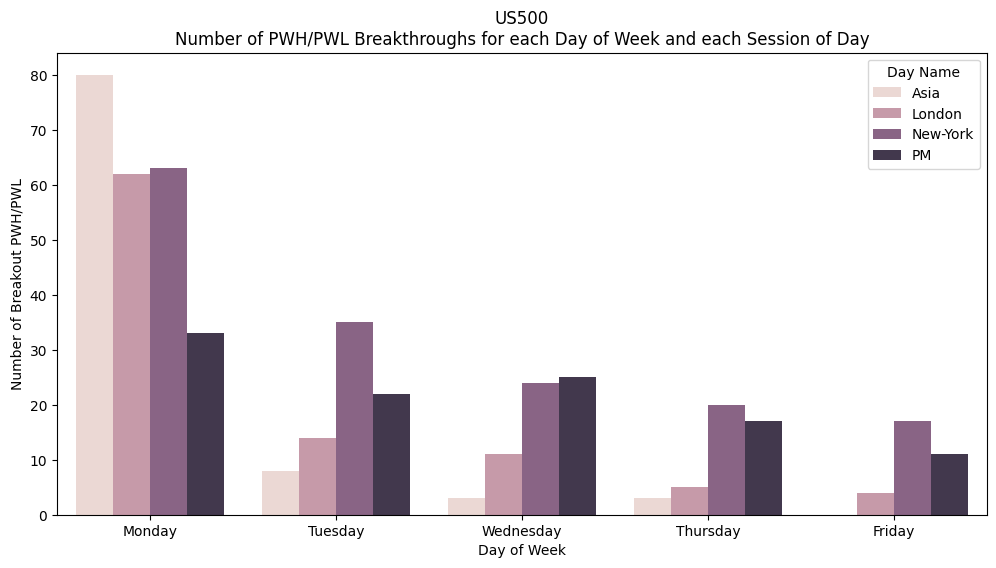

In [7]:
# Plotting Data for Analyzed
dfs_days_for_plot = [btc_an_days_grouped, eu_an_days_grouped, us500_an_days_grouped]
dfs_days_session_for_plot = [eu_an_days_sessions_grouped, btc_an_days_sessions_grouped, us500_an_days_sessions_grouped]
names = ['BTCUSDT','EURUSD', 'US500']

plotting_diagrams(dfs_for_plot=dfs_days_for_plot, name=names)
plotting_diagrams(dfs_for_plot=dfs_days_session_for_plot, name=names, session=True)